# Classification using Gradient Boost
## Goal
 - Tune hyperparameters for Gradient Boost model

##  Conclusion
 - Final model has very high accuracy (0.98 for training and 0.96 for test)
 - Final model has decent recall (0.88 for training and 0.79 for test)
 - Final model has fairly high precision (0.98 for training and 0.91 for test)

In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import GradientBoostingClassifier

# Transformers
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from imblearn.over_sampling import SMOTE

# Model Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, f1_score, precision_score, recall_score

# Pipelines
from imblearn.pipeline import Pipeline

### Import Data

In [2]:
df = pd.read_csv('../../data/processed/churn_dataset.csv', index_col = 0)
X = df.drop(columns = 'churn')
y = df.churn

random_state = 45
cv = 5

### Calculate baseline F1-Score

In [3]:
X_train_all, X_hold_out, y_train_all, y_hold_out = train_test_split(X, y, random_state = random_state)
number_selector = make_column_selector(dtype_include='number')
string_selector = make_column_selector(dtype_include='object')
preprocessing = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), string_selector),
                                        (StandardScaler(), number_selector),
                                        remainder='passthrough')
gbm = GradientBoostingClassifier(random_state = random_state)
pipeline = Pipeline([('preprocessing', preprocessing),
                     ('sm', SMOTE(random_state = random_state)), 
                     ('gb', gbm)])
pipeline.fit(X_train_all, y_train_all)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb85720ae50>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb85727d220>)])),
                ('sm', SMOTE(random_state=45)),
                ('gb', GradientBoostingClassifier(random_state=45))])

In [4]:
train_preds = pipeline.predict(X_train_all)
hold_out_preds = pipeline.predict(X_hold_out)

train_f1 = f1_score(y_train_all, train_preds)
test_f1 = f1_score(y_hold_out, hold_out_preds)
print('Baseline Training F1-Score: {:.2f}'.format(train_f1))
print('Baseline Testing F1-Score: {:.2f}'.format(test_f1))

Baseline Training F1-Score: 0.85
Baseline Testing F1-Score: 0.77


### Tune Hyperparameters
- Use max_depth, min_samples_leaf and max_leaf_nodes from Decision Tree tuning

In [5]:
param_grid = {'gb__n_estimators':(25, 50, 75, 100, 125, 150), 
              'gb__loss':('deviance', 'exponential'),
              'gb__max_depth':[5],
              'gb__min_samples_leaf':[50],
              'gb__max_leaf_nodes':[15],
              'gb__max_features':(None, 'auto', 'sqrt', 'log2'), 
              'gb__warm_start':(True, False)}
grid_search = GridSearchCV(pipeline, param_grid, scoring = 'f1')
grid_search.fit(X_train_all, y_train_all)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fb85720ae50>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at...d220>)])),
                                       ('sm', SMOTE(random_state=45)),
                                       ('gb',
                                        Gradi

In [6]:
print('Training F1-Score: {:.2f}'.format(grid_search.score(X_train_all, y_train_all)))
print('Test F1-Score: {:.2f}'.format(grid_search.score(X_hold_out, y_hold_out)))

Training F1-Score: 0.92
Test F1-Score: 0.85


In [7]:
grid_search.best_params_

{'gb__loss': 'deviance',
 'gb__max_depth': 5,
 'gb__max_features': None,
 'gb__max_leaf_nodes': 15,
 'gb__min_samples_leaf': 50,
 'gb__n_estimators': 150,
 'gb__warm_start': True}

### Instantiate final model

In [8]:
gbm = GradientBoostingClassifier(random_state = random_state, 
                                 loss = 'deviance', max_depth = 5, 
                                 max_features = None, max_leaf_nodes = 15, 
                                 min_samples_leaf = 50,
                                 n_estimators = 150, warm_start = True)
pipeline = Pipeline([('preprocessing', preprocessing),
                     ('sm', SMOTE(random_state = random_state)), 
                     ('gb', gbm)])
pipeline.fit(X_train_all, y_train_all)

train_preds = pipeline.predict(X_train_all)
hold_out_preds = pipeline.predict(X_hold_out)
train_f1 = f1_score(y_train_all, train_preds)
test_f1 = f1_score(y_hold_out, hold_out_preds)
print('Training F1-Score: {:.2f}'.format(train_f1))
print('Testing F1-Score: {:.2f}'.format(test_f1))

Training F1-Score: 0.92
Testing F1-Score: 0.85


### Check Confusion Matrices and Calculate Accuracy

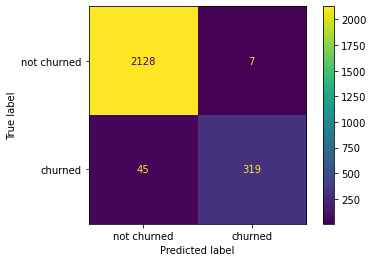

In [9]:
plot_confusion_matrix(pipeline, X_train_all, y_train_all, display_labels=['not churned', 'churned'])

In [10]:
print('Training Accuracy: {:.2f}'.format(pipeline.score(X_train_all, y_train_all)))
print('Training Recall: {:.2f}'.format(recall_score(y_train_all, train_preds)))
print('Training Precision: {:.2f}'.format(precision_score(y_train_all, train_preds)))

Training Accuracy: 0.98
Training Recall: 0.88
Training Precision: 0.98


***Notes***
- Training accuracy is very high
- Training recall is decent
- Training Precision is very high

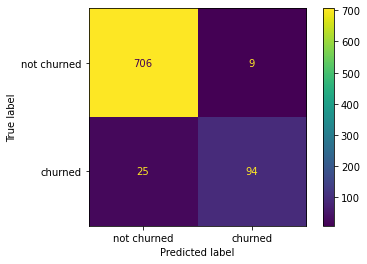

In [11]:
plot_confusion_matrix(pipeline, X_hold_out, y_hold_out, display_labels=['not churned', 'churned'])

In [12]:
print('Test Accuracy: {:.2f}'.format(pipeline.score(X_hold_out, y_hold_out)))
print('Test Recall: {:.2f}'.format(recall_score(y_hold_out, hold_out_preds)))
print('Test Precision: {:.2f}'.format(precision_score(y_hold_out, hold_out_preds)))

Test Accuracy: 0.96
Test Recall: 0.79
Test Precision: 0.91


***Notes***
- Training accuracy is very high
- Training recall is decent
- Training Precision is fairly high